In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qutip as qt

In [35]:
### "configuration" parameters
squeeze_drive = True
x_drive = True

tmax = 1.
arg_e_2 = 0.

### units
MHz = 1. # work in units of MHz
hbar = 1. # work in units where hbar = 1

### system parameters
omega_a = 6.0e3 * MHz
N = 10 # 10-d Hilbert space

K = 2. * np.pi * 6.7 * MHz # Kerr nonlinearity
g_3 = 2. * np.pi * 20.0 * MHz # third-order nonlinearity
e_2 = np.exp(1.j * arg_e_2) * 2. * np.pi * 15.5 * MHz if squeeze_drive else 0. # squeezing drive strength
xi = e_2 / (3. * g_3) # (e_2 / omega_a) - (np.conj(e_2) / (3. * omega_a))
T_1 = 15.5 / MHz # single-photon decay time
k_a = 1. / T_1
n_th = 0.04 # equilibrium thermal |1>-state occupation

alpha = np.sqrt(e_2 / K)

In [36]:
### define the basis states
C_0 = (qt.coherent(N, alpha) + qt.coherent(N, -alpha)) / np.sqrt(2. * (1. + np.exp(-2. * np.abs(alpha)**2)))
C_1 = (qt.coherent(N, alpha) - qt.coherent(N, -alpha)) / np.sqrt(2. * (1. - np.exp(-2. * np.abs(alpha)**2)))

In [37]:
t = np.arange(0., tmax, 0.001) # 1 μs

psi0 = C_0 #(C_0 + C_1) / np.sqrt(2)
rho0 = psi0 * psi0.dag()

N_ex = 100
arg_e_x = np.linspace(-np.pi, np.pi, N_ex)
e_x_array = np.exp(1.j * arg_e_x) * 2. * np.pi * 740.0e-3 * MHz if x_drive else 0. # x-rotation drive strength

P_0 = np.empty((N_ex, t.size))
for i, e_x in enumerate(e_x_array):
    
    ### the Hamiltonian
    H_sys = hbar * (-K * qt.create(N)**2 * qt.destroy(N)**2 + e_2 * qt.create(N)**2 + np.conj(e_2) * qt.destroy(N)**2
             - 4. * K * np.abs(xi)**2 * qt.create(N) * qt.destroy(N) + e_x * qt.create(N) + np.conj(e_x) * qt.destroy(N))

    result = qt.mesolve(H_sys, rho0, t,
                        c_ops=[np.sqrt(k_a * (1. * n_th)) * qt.destroy(N), np.sqrt(k_a * n_th) * qt.create(N)],
                       options=qt.Options(store_states=True))

    P_0[i] = np.array([x.full() for x in C_0.dag() * result.states * C_0]).flatten().real

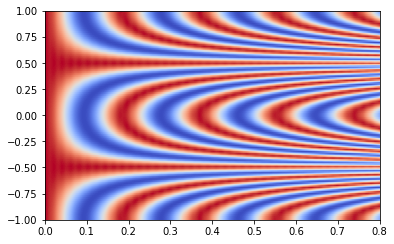

In [38]:
plt.imshow(P_0, cmap="coolwarm", extent=[0., 0.8, -1., 1.], aspect=0.25)